In [17]:
import yfinance as yf
from datetime import date
import pandas as pd
import numpy as np
from sklearn import metrics
from math import sqrt
import matplotlib.pyplot as plt


In [18]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [19]:
# Input dari pengguna untuk simbol saham
symbol = input("Masukkan simbol saham (misalnya 'AAPL'): ")
start_date = date(2019, 1, 1)
end_date = date(2024, 3, 31)

# Mengunduh data saham dari Yahoo Finance # Menambahkan kolom tanggal sebagai indeks
data = yf.download(symbol, start=start_date, end=end_date)
data.reset_index(inplace=True)

# Input dari pengguna untuk fitur yang akan digunakan
input_feat = input("Masukkan fitur yang akan digunakan ('Adj Close','Close'): ")


data = data[["Date", input_feat]]# Memilih kolom tanggal dan fitur yang akan digunakan
data

c:\Users\kevin\miniconda3\envs\tf\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


,Date,Close
0,2019-01-01,3327.215332
1,2019-01-02,3281.761475
2,2019-01-03,3290.852295
3,2019-01-04,3327.215332
4,2019-01-07,3327.215332
...,...,...
1285,2024-03-22,6125.000000
1286,2024-03-25,6250.000000
1287,2024-03-26,6300.000000
1288,2024-03-27,6250.000000


In [20]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[input_feat].values.reshape(-1, 1))

In [21]:
# Pembagian data menjadi data latih dan data uji
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size, :], scaled_data[train_size:, :]

In [22]:
# Persiapan Create Sequences LSTM
def create_sequences(data, sequence_length):
    sequences = []
    target = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
        target.append(data[i+sequence_length])
    return np.array(sequences), np.array(target)

In [23]:
tf.random.set_seed(7)

In [24]:
sequence_length = 1
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

In [25]:
model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 50)             10400     
                                                                 
 dropout_3 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 50)             20200     
                                                                 
 dropout_4 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [26]:
# cp3 = ModelCheckpoint('../model/model2/', save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2, callbacks=[early_stopping], validation_data=(X_test, y_test))

Epoch 1/100
33/33 - 8s - loss: 0.1467 - accuracy: 9.6993e-04 - val_loss: 0.3098 - val_accuracy: 0.0000e+00 - 8s/epoch - 231ms/step
Epoch 2/100
33/33 - 1s - loss: 0.0244 - accuracy: 9.6993e-04 - val_loss: 0.0715 - val_accuracy: 0.0039 - 682ms/epoch - 21ms/step
Epoch 3/100
33/33 - 1s - loss: 0.0116 - accuracy: 9.6993e-04 - val_loss: 0.0493 - val_accuracy: 0.0039 - 520ms/epoch - 16ms/step
Epoch 4/100
33/33 - 1s - loss: 0.0097 - accuracy: 9.6993e-04 - val_loss: 0.0354 - val_accuracy: 0.0039 - 511ms/epoch - 15ms/step
Epoch 5/100
33/33 - 0s - loss: 0.0078 - accuracy: 9.6993e-04 - val_loss: 0.0196 - val_accuracy: 0.0039 - 486ms/epoch - 15ms/step
Epoch 6/100
33/33 - 0s - loss: 0.0056 - accuracy: 9.6993e-04 - val_loss: 0.0085 - val_accuracy: 0.0039 - 452ms/epoch - 14ms/step
Epoch 7/100
33/33 - 0s - loss: 0.0044 - accuracy: 9.6993e-04 - val_loss: 0.0015 - val_accuracy: 0.0039 - 430ms/epoch - 13ms/step
Epoch 8/100
33/33 - 0s - loss: 0.0032 - accuracy: 9.6993e-04 - val_loss: 0.0015 - val_accuracy:

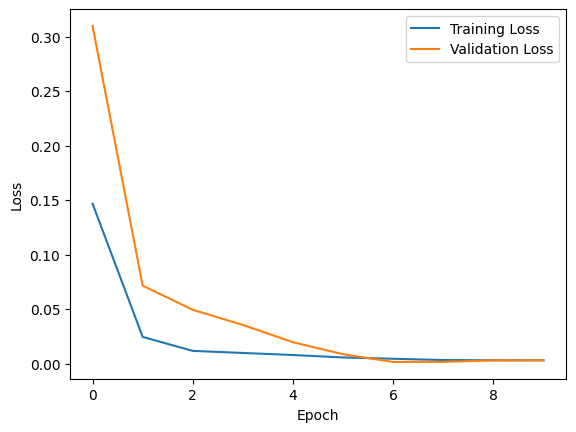

In [27]:
# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
# Evaluasi model pada data uji
loss = model.evaluate(X_test, y_test)
print("Loss di data uji:", loss)

print("Loss di data uji:", loss)
predict = model.predict(X_test)
# print(predict)

9/9 [==============================] - 0s 7ms/step - loss: 0.0015 - accuracy: 0.0039
Loss di data uji: [0.0014810708817094564, 0.0038910505827516317]
Loss di data uji: [0.0014810708817094564, 0.0038910505827516317]
9/9 [==============================] - 1s 8ms/step


In [29]:

print("-"*50, " Metric ","-"*50)
print('RMSE : ',sqrt(metrics.mean_squared_error(y_test,predict)))
print('MSE  :  ',metrics.mean_squared_error(y_test,predict))
print('MAE  :  ',metrics.mean_absolute_error(y_test,predict))
print("-"*26, " Mengecek Apakah Nilainya Overfit atau tidak ","-"*26)


--------------------------------------------------  Metric  --------------------------------------------------
RMSE :  0.03848468363978816
MSE  :   0.0014810708748545782
MAE  :   0.03469251100270509
--------------------------  Mengecek Apakah Nilainya Overfit atau tidak  --------------------------


In [30]:
# # Simpan model
# model.save("../home-page-stock-prediction/lstm_model2.keras")
# print("Successfully saved model")


import time

ts = int(time.time())
file_path = f"../lstm_stock/{ts}/"
model.save(filepath=file_path, save_format='tf')
print("Sucess saving model!")

INFO:tensorflow:Assets written to: ../lstm_stock/1713692747/assets


INFO:tensorflow:Assets written to: ../lstm_stock/1713692747/assets


Sucess saving model!
